In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Literal
from collections import defaultdict
import pandas as pd

### Define model + functions to compute advantage estimates

In [3]:
class Model:
    def __init__(self, n_tokens: int = 20):
        self.logits = torch.zeros((n_tokens,))
        n = 1 / (n_tokens + 1)
        self.token_to_prob = torch.linspace(n, 1 - n, n_tokens)

    def sample_probs(self, shape, return_tokens=False):
        tokens = torch.distributions.Categorical(logits=self.logits).sample(shape)
        probs = self.token_to_prob[tokens]
        if return_tokens:
            return probs, tokens
        return probs
    
    def log_prob(self, tokens):
        log_probs = torch.distributions.Categorical(logits=self.logits).log_prob(tokens)
        return log_probs
    
    def compute_true_advantage(self, p: float, reward_mode: Literal["llk", "brier"] = "llk"):
        token_probs = torch.softmax(self.logits, dim=0)
        probs = self.token_to_prob
        if reward_mode == "llk":
            Q = p * torch.log(probs) + (1-p) * torch.log(1 - probs)
        else:
            Q = -(p * (1 - probs) ** 2 + (1-p) * probs ** 2)
        V = (token_probs * Q).sum()
        A = Q - V
        return probs, A
    
    def estimate_grpo_no_std_advantage(self, p: float, g: int = 100, n_samples: int = 1000, reward_mode: Literal["llk", "brier"] = "llk"):
        pred_probs, pred_tokens = self.sample_probs((n_samples, g), return_tokens=True)
        answers = torch.distributions.Bernoulli(probs=torch.Tensor([p])).sample((n_samples,))
        rewards = compute_rewards(pred_probs, answers, reward_mode)
        group_mean_rewards = rewards.mean(-1, keepdim=True)
        A_hat = rewards - group_mean_rewards
        A_hat_expected = torch.zeros_like(self.logits)
        A_hat_expected.scatter_reduce_(dim=0, index=pred_tokens.flatten(), src=A_hat.flatten(), reduce="mean")
        counts = torch.zeros_like(self.logits)
        counts.scatter_reduce_(dim=0, index=pred_tokens.flatten(), src=torch.ones_like(A_hat.flatten()), reduce="sum")
        sigma_0 = rewards[answers.squeeze() == 0].mean()
        sigma_1 = rewards[answers.squeeze() == 1].mean()
        return A_hat_expected, counts, sigma_0, sigma_1
    
    def estimate_grpo_advantage(self, p: float, g: int = 100, n_samples: int = 1000, reward_mode: Literal["llk", "brier"] = "llk"):
        pred_probs, pred_tokens = self.sample_probs((n_samples, g), return_tokens=True)
        answers = torch.distributions.Bernoulli(probs=torch.Tensor([p])).sample((n_samples,))
        rewards = compute_rewards(pred_probs, answers, reward_mode)
        group_mean_rewards = rewards.mean(-1, keepdim=True)
        group_std_rewards = rewards.std(-1, keepdim=True)
        eps = 1e-5
        A_hat = (rewards - group_mean_rewards) / (group_std_rewards + eps)
        A_hat_expected = torch.zeros_like(self.logits)
        A_hat_expected.scatter_reduce_(dim=0, index=pred_tokens.flatten(), src=A_hat.flatten(), reduce="mean")
        counts = torch.zeros_like(self.logits)
        counts.scatter_reduce_(dim=0, index=pred_tokens.flatten(), src=torch.ones_like(A_hat.flatten()), reduce="sum")
        sigma_0 = rewards[answers.squeeze() == 0].std(dim=-1).mean()
        sigma_1 = rewards[answers.squeeze() == 1].std(dim=-1).mean()
        return A_hat_expected, counts, sigma_0, sigma_1
    
def compute_rewards(pred_probs, answers, reward_mode):
    if reward_mode == "llk":
        rewards = answers * torch.log(pred_probs) + (1-answers) * torch.log(1-pred_probs)
    elif reward_mode == "brier":
        rewards = -(answers - pred_probs) ** 2
    else:
        raise ValueError("Unknown reward_mode", reward_mode)
    return rewards

In [4]:
def plot_policy(model, p):
    plt.figure(figsize=(3,1.5))
    plt.plot(model.token_to_prob, torch.softmax(model.logits, dim=0), c="k")
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.xlabel("")
    plt.ylabel("")
    plt.axvline(p, 0, 1, color="gray", ls="--")

def compute_advantages(model, p, g, n_samples, reward_mode):
    probs, advantages = model.compute_true_advantage(p=p, reward_mode=reward_mode)
    A_hat_no_std, counts_no_std, sigma_0_no_std, sigma_1_no_std = model.estimate_grpo_no_std_advantage(p=p, g=g, n_samples=n_samples, reward_mode=reward_mode)
    A_hat_std, counts_std, sigma_0_std, sigma_1_std = model.estimate_grpo_advantage(p=p, g=g, n_samples=n_samples, reward_mode=reward_mode)
    out = dict(
        probs=probs,
        true_p=p,
        advantages=advantages,
        grpo_no_std_advantages=A_hat_no_std,
        grpo_no_std_counts=counts_no_std,
        grpo_no_std_sigma_0=sigma_0_no_std,
        grpo_no_std_sigma_1=sigma_1_no_std,
        grpo_advantages=A_hat_std,
        grpo_counts=counts_std,
        grpo_std_sigma_0=sigma_0_std,
        grpo_std_sigma_1=sigma_1_std,
    )
    return out

def plot_advantages(advantages_dict, legend=False, min_n=250):
    plt.figure(figsize=(3,2))    
    # true advantages
    plt.plot(advantages_dict["probs"], advantages_dict["advantages"], "k--", label="True", lw=0.9, zorder=10)
    
    # GRPO no std
    idx = advantages_dict["grpo_no_std_counts"] > min_n
    x = advantages_dict["probs"][idx].numpy()
    y = advantages_dict["grpo_no_std_advantages"][idx].numpy()
    plt.plot(x, y, alpha=0.8, label="GRPO w/o Std Norm", lw=3)
    
    # GRPO
    idx = advantages_dict["grpo_counts"] > min_n
    x = advantages_dict["probs"][idx].numpy()
    y = advantages_dict["grpo_advantages"][idx].numpy()
    plt.plot(x, y, alpha=0.8, label="GRPO", lw=3)

    # formatting
    plt.gca().spines[["right", "top"]].set_visible(False)
    if legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.axvline(advantages_dict["true_p"], 0, 1, color="gray", ls="--")

def plot_std_devs(policy_adv_dict):
    curr = defaultdict(list)
    for policy_key, d in policy_adv_dict.items():
        for i in range(2):
            curr["Policy"].append(policy_key.capitalize())
            curr["key"].append(f"$\\sigma_{i}$")
            curr["Value"].append(d[f"grpo_std_sigma_{i}"].item())
    plt.figure(figsize=(4,3))
    sns.barplot(data=pd.DataFrame(curr), x="Policy", y="Value", hue="key", edgecolor="k")
    sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5), title="", frameon=False)
    plt.gca().spines[["right", "top"]].set_visible(False)
    

In [5]:
outdir = Path("images/explanation/")
outdir.mkdir(exist_ok=True, parents=True)

In [6]:
policy_params = {
    "uniform": (1, 1),
    "concentrated": (5.7, 3),
    "overconfident": (50, 1),
}

policies = {}
for k, (alpha, beta) in policy_params.items():
    model = Model(n_tokens=100)
    model.logits = torch.distributions.Beta(
        alpha * torch.ones((1,)),
        beta*torch.ones((1,))
    ).log_prob(model.token_to_prob)
    policies[k] = model

In [7]:
advantage_info = {}
for reward_mode in ["llk", "brier"]:
    curr = {}
    for k, policy in policies.items():
        print(k)
        curr[k] = compute_advantages(policy, p=0.7, g=1_000, n_samples=100_000, reward_mode=reward_mode)
    advantage_info[reward_mode] = curr

uniform
concentrated
overconfident
uniform
concentrated
overconfident


In [8]:
advantage_info.keys()

dict_keys(['llk', 'brier'])

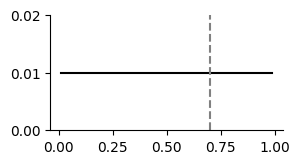

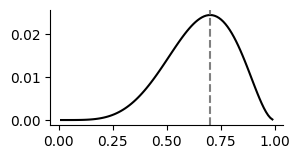

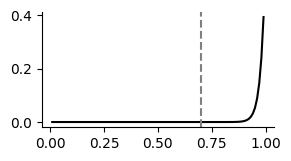

In [9]:
for k, policy in policies.items():
    plot_policy(policy, p=0.7)
    if k == "uniform":
        plt.yticks([0, 0.01, 0.02])
    plt.savefig(outdir / f"{k}_policy.png", transparent=True, dpi=200, bbox_inches="tight")
    plt.show(plt.gcf())
    plt.close()


llk


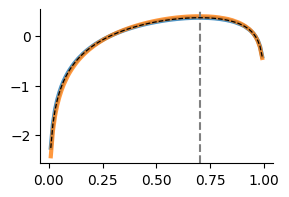

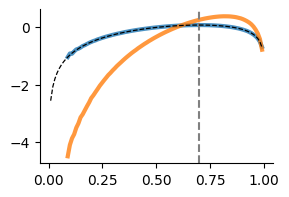

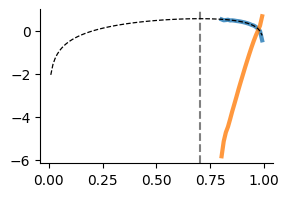

brier


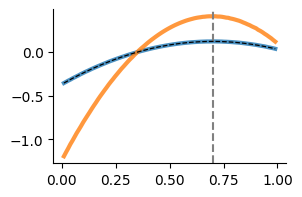

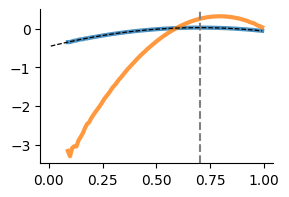

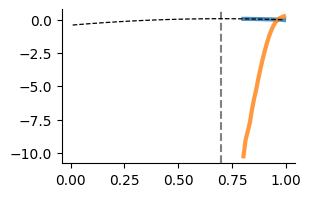

In [10]:
for reward_mode, curr_adv_dict in advantage_info.items():
    print(reward_mode)
    for policy_mode, adv_dict in curr_adv_dict.items():
        plot_advantages(adv_dict, legend=False, min_n=1000)
        plt.savefig(outdir / f"{reward_mode}_{policy_mode}_advantages.png", transparent=True, dpi=200, bbox_inches="tight")
        plt.show(plt.gcf())
        plt.close()


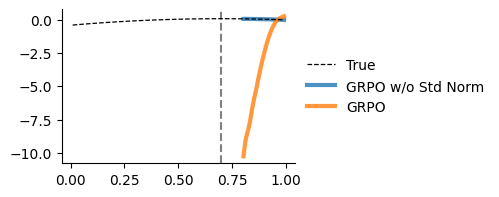

In [11]:
plot_advantages(adv_dict, legend=True, min_n=1000)
plt.savefig(outdir / f"legend.png", transparent=True, dpi=200, bbox_inches="tight")

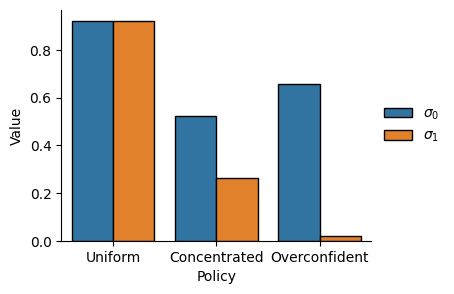

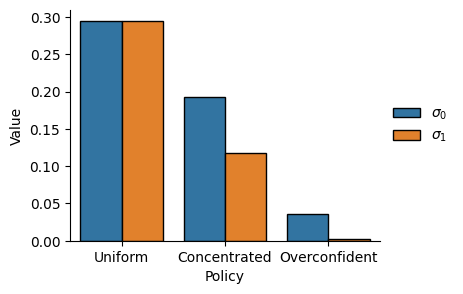

In [12]:
for k in advantage_info:
    plot_std_devs(advantage_info[k])
    plt.savefig(outdir / f"sigma_{k}.png", transparent=True, dpi=200, bbox_inches="tight")
    plt.show(plt.gcf())
    plt.close()